In [631]:
import os, io
from pathlib import Path
import math
from collections import defaultdict, Counter, deque
from heapq import heapify, heappush, heappop
from itertools import chain
from dataclasses import dataclass, field
import itertools
import sqlite3
import logging
import logging.handlers
import multiprocessing as mp

from tqdm.notebook import tqdm
from PIL import Image, ImageDraw, ImageFilter, ImageEnhance

import numpy as np
import cupy as cp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import preprocessing
from scipy.interpolate import RegularGridInterpolator
from numba import jit

from utils import *
from hdc import *

In [142]:
LOG = Logging()

config_var = 'SQLITE3_VECTOR_GRID_0_1024'
config = Config(config_var)
RNG = np.random.default_rng()

if cp.cuda.is_available():
    xp = cp.get_array_module(cp.empty(1))
    xp_array_from_gpu = lambda a: a.get() if isinstance(a, cp.ndarray) else a
    xp_array_to_gpu = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
    xp_array_to_gpu_copy = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
else:
    xp = cp.get_array_module(np.empty(1))
    xp_array_from_gpu = lambda a: a
    xp_array_to_gpu = lambda a: a
    xp_array_to_gpu_copy = lambda a: a.copy()

print(f'xp = {xp.__name__}')

hdc = Hdc(config.hdc_n, np)

xp = numpy


In [143]:
def ensure_dataset_folder():
    if not os.path.exists(config.dataset_path):
        print(f'Creating "{config.dataset_path}"')
        os.mkdir(config.dataset_path)

def is_table_exists(db_con, table_name):
    df = pd.read_sql('SELECT name FROM sqlite_master WHERE type=:type AND name=:table_name', params={'type': 'table', 'table_name': table_name}, con=db_con)
    return len(df) > 0

def is_table_empty(db_con, table_name):
    cur = train_db_con.cursor() 
    return len(cur.execute(f'SELECT * FROM {table_name} LIMIT 1').fetchall()) < 1

def drop_table_safe(db_con, tn):
    if is_table_exists(db_con, tn):
        db_con.cursor().execute(f'DROP TABLE {tn}')
        db_con.commit()

def get_full_db_file_name(db_file_name):
    return os.path.join(config.dataset_path, config.db_file_name_prefix + db_file_name)

ensure_dataset_folder()
hdv_db_con = sqlite3.connect(get_full_db_file_name(config.hdv_db_file_name), autocommit=False)
train_db_con = sqlite3.connect(get_full_db_file_name(config.train_db_file_name), autocommit=False)
test_db_con = sqlite3.connect(get_full_db_file_name(config.test_db_file_name), autocommit=False)

# Load MNIST

In [144]:
dataset_source = os.path.join(config.dataset_source)

In [145]:
import struct
from array import array

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        
        images = []
        
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images.append(img)
        
        return np.array(images), np.array(labels)
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)     

CPU times: user 115 ms, sys: 65.3 ms, total: 180 ms
Wall time: 179 ms


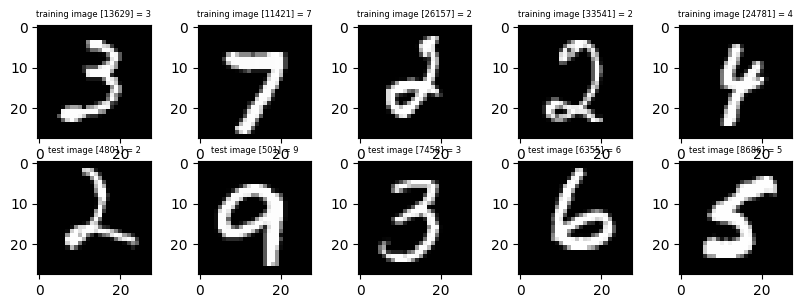

In [146]:
%%time
import random

#
# Set file paths based on added MNIST Datasets
#
training_images_filepath = os.path.join(dataset_source, 'train-images-idx3-ubyte')
training_labels_filepath = os.path.join(dataset_source, 'train-labels-idx1-ubyte')
test_images_filepath = os.path.join(dataset_source, 't10k-images-idx3-ubyte')
test_labels_filepath = os.path.join(dataset_source, 't10k-labels-idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(10,5))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 6);        
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

# Show some random training and test images 
images_2_show = []
titles_2_show = []
for i in range(0, 5):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

# Sensor

In [147]:
SENSOR_RECEPTIVE_FIELD_SIZE = 8
SENSOR_RECEPTIVE_FIELD_SQUARE = SENSOR_RECEPTIVE_FIELD_SIZE ** 2

SENSORS_COUNT = config.sensors_count
SENSORS_COUNT_ROOT = int(np.sqrt(SENSORS_COUNT))
assert SENSORS_COUNT_ROOT ** 2 == SENSORS_COUNT
assert SENSORS_COUNT_ROOT > 1


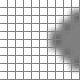
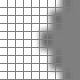
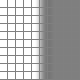
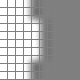
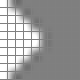
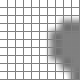
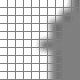
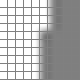
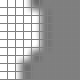
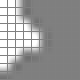
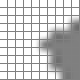
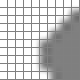
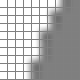
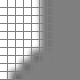
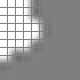
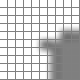
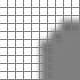
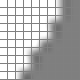
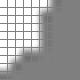
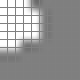

In [148]:
SENSOR_STATES_INFO = defaultdict(list)
SENSOR_STATES_IMG = []
sz = SENSOR_RECEPTIVE_FIELD_SIZE
captions = []

assert config.encoding_type == 'vector'

angle_step = 10 # degrees
angles = list(range(0, 360, angle_step)) + [45 * 1, 45 * 3, 45 * 5, 45 * 7]
angles = sorted(angles)
# sweeps = [50, 90, 130, 180, 230, 270, 310] # for receptive field size = 8 more finer sweeps make little sense 
sweeps = [90, 130, 180, 230, 270] # for receptive field size = 8 more finer sweeps make little sense 

for angle in angles:
    # for sweep in range(angle_step, 180 + angle_step, angle_step):
    for sweep in sweeps:
        canvas = Image.new('L', (sz, sz))
        draw = ImageDraw.Draw(canvas)
        draw.rectangle([0, 0, sz, sz], fill=127, outline=127)
        piesclice_angle1 = angle + sweep // 2
        piesclice_angle2 = angle - sweep // 2
        draw.pieslice([-sz, -sz, sz * 2 - 1, sz * 2 - 1], start=piesclice_angle1, end=piesclice_angle2, fill=255, outline=255, width=0)
        captions.append(f'ang={angle}, swp={sweep} ')
        SENSOR_STATES_IMG.append(canvas)
        SENSOR_STATES_INFO['normal'].append(angle)
        SENSOR_STATES_INFO['sweep'].append(sweep)
        SENSOR_STATES_INFO['normal_vec'].append(np.exp((1j) * np.radians(angle)))
        SENSOR_STATES_INFO['sweep1_vec'].append(np.exp((1j) * np.radians(piesclice_angle1)))
        SENSOR_STATES_INFO['sweep2_vec'].append(np.exp((1j) * np.radians(piesclice_angle2)))

SENSOR_STATES_INFO = pd.DataFrame(SENSOR_STATES_INFO)
assert len(SENSOR_STATES_INFO) == len(SENSOR_STATES_IMG)
n_to_show = len(sweeps) * 4
images_to_show = list(map(lambda x: lay_grid(x.resize((80, 80)), 8), SENSOR_STATES_IMG[:n_to_show]))
display_images_grid(images_to_show, captions=captions[:n_to_show], col_count=len(sweeps) )

In [149]:
SENSOR_STATES_INFO.head()

,normal,sweep,normal_vec,sweep1_vec,sweep2_vec
0,0,90,1.0+0.0j,0.707107+0.707107j,0.707107-0.707107j
1,0,130,1.0+0.0j,0.422618+0.906308j,0.422618-0.906308j
2,0,180,1.0+0.0j,0.000000+1.000000j,0.000000-1.000000j
3,0,230,1.0+0.0j,-0.422618+0.906308j,-0.422618-0.906308j
4,0,270,1.0+0.0j,-0.707107+0.707107j,-0.707107-0.707107j


In [150]:
SENSOR_STATES_INFO.tail()

,normal,sweep,normal_vec,sweep1_vec,sweep2_vec
195,350,90,0.984808-0.173648j,0.819152+0.573576j,0.573576-0.819152j
196,350,130,0.984808-0.173648j,0.573576+0.819152j,0.258819-0.965926j
197,350,180,0.984808-0.173648j,0.173648+0.984808j,-0.173648-0.984808j
198,350,230,0.984808-0.173648j,-0.258819+0.965926j,-0.573576-0.819152j
199,350,270,0.984808-0.173648j,-0.573576+0.819152j,-0.819152-0.573576j


In [151]:
# Turn grayscale images of sensor states to numpy arrays with weights which balance positive and negative areas
SENSOR_STATES = np.array(list(map(np.array, SENSOR_STATES_IMG))).astype(float)
SENSOR_STATES = SENSOR_STATES.reshape(-1, SENSOR_RECEPTIVE_FIELD_SIZE ** 2)
SENSOR_STATES[SENSOR_STATES == 255] = 1
SENSOR_STATES[SENSOR_STATES == 127] = -1
assert set(np.unique(SENSOR_STATES)) == set([-1, +1])

SENSOR_STATES_COUNT = SENSOR_STATES.shape[0]
SENSOR_STATES.shape, np.unique_counts(SENSOR_STATES)

((200, 64),
 UniqueCountsResult(values=array([-1.,  1.]), counts=array([5942, 6858])))

In [152]:
SENSOR_STATE_AREAS_POS = (SENSOR_STATES == 1).sum(axis=1) 
SENSOR_STATE_AREAS_NEG = (SENSOR_STATES == -1).sum(axis=1)
assert np.all(SENSOR_STATE_AREAS_POS > 0)
assert np.all(SENSOR_STATE_AREAS_NEG > 0)
SENSOR_STATE_AREAS_POS.shape, SENSOR_STATE_AREAS_POS.mean(), SENSOR_STATE_AREAS_POS.std(), \
SENSOR_STATE_AREAS_NEG.shape, SENSOR_STATE_AREAS_NEG.mean(), SENSOR_STATE_AREAS_NEG.std()

((200,),
 np.float64(34.29),
 np.float64(11.739075772819596),
 (200,),
 np.float64(29.71),
 np.float64(11.739075772819596))

In [153]:
SENSOR_STATES_POS = xp_array_to_gpu_copy(SENSOR_STATES)
SENSOR_STATES_NEG = xp_array_to_gpu_copy(SENSOR_STATES)
SENSOR_STATES_POS[SENSOR_STATES_POS < 0] = 0
SENSOR_STATES_NEG[SENSOR_STATES_NEG > 0] = 0

In [154]:
np.unique_counts(SENSOR_STATES_POS),np.unique_counts(SENSOR_STATES_NEG)

(UniqueCountsResult(values=array([0., 1.]), counts=array([5942, 6858])),
 UniqueCountsResult(values=array([-1.,  0.]), counts=array([5942, 6858])))

# Retina

In [155]:
class SensorLayoutMaker(object):
    def __call__(self, sensor_index):
        return None

class SensorLayoutMaker_Grid(SensorLayoutMaker):
    def __init__(self):
        self.s = SENSORS_COUNT_ROOT
        self.field_size = SENSOR_RECEPTIVE_FIELD_SIZE
        space_for_sensors = self.s * self.field_size 
        self.dist_between_sensors = (config.sample_size - space_for_sensors) / (self.s - 1)
        
    def __call__(self, sensor_index):
        x = int((sensor_index % self.s) * (self.field_size + self.dist_between_sensors))
        y = int((sensor_index // self.s) * (self.field_size + self.dist_between_sensors))
        # adjust to fit into boundaries
        x -= max(0, (x + self.field_size) - config.sample_size) 
        y -= max(0, (y + self.field_size) - config.sample_size)
        return x, y, self.field_size

In [156]:
SENSOR_LAYOUT_MAKER = None

match config.retina_layout:
    case 'grid': 
        SENSOR_LAYOUT_MAKER = SensorLayoutMaker_Grid()
    case _:
        assert False, config.retina_layout

In [157]:
assert not SENSOR_LAYOUT_MAKER is None
SENSOR_INSTANCES_INFO = pd.DataFrame(columns=['x_offset', 'y_offset', 'size', 'bounds_rect', 'x_center', 'y_center', 'radius'])

for i in range(SENSORS_COUNT):
    x_offset, y_offset, field_size = SENSOR_LAYOUT_MAKER(i)
    assert x_offset >= 0 and x_offset <= config.sample_size - field_size, (i, x_offset, field_size)
    assert y_offset >= 0 and y_offset <= config.sample_size - field_size, (i, y_offset, field_size)
    SENSOR_INSTANCES_INFO.loc[len(SENSOR_INSTANCES_INFO)] = [
        x_offset,
        y_offset,
        field_size,
        [x_offset, y_offset, x_offset + field_size - 1, y_offset + field_size - 1],
        x_offset + field_size // 2,
        y_offset + field_size // 2,
        field_size // 2
    ]

SENSOR_INSTANCES_INFO

,x_offset,y_offset,size,bounds_rect,x_center,y_center,radius
0,0,0,8,"[0, 0, 7, 7]",4,4,4
1,1,0,8,"[1, 0, 8, 7]",5,4,4
2,3,0,8,"[3, 0, 10, 7]",7,4,4
3,5,0,8,"[5, 0, 12, 7]",9,4,4
4,7,0,8,"[7, 0, 14, 7]",11,4,4
...,...,...,...,...,...,...,...
4091,112,120,8,"[112, 120, 119, 127]",116,124,4
4092,114,120,8,"[114, 120, 121, 127]",118,124,4
4093,116,120,8,"[116, 120, 123, 127]",120,124,4
4094,118,120,8,"[118, 120, 125, 127]",122,124,4


CPU times: user 98.2 ms, sys: 782 μs, total: 99 ms
Wall time: 97.7 ms


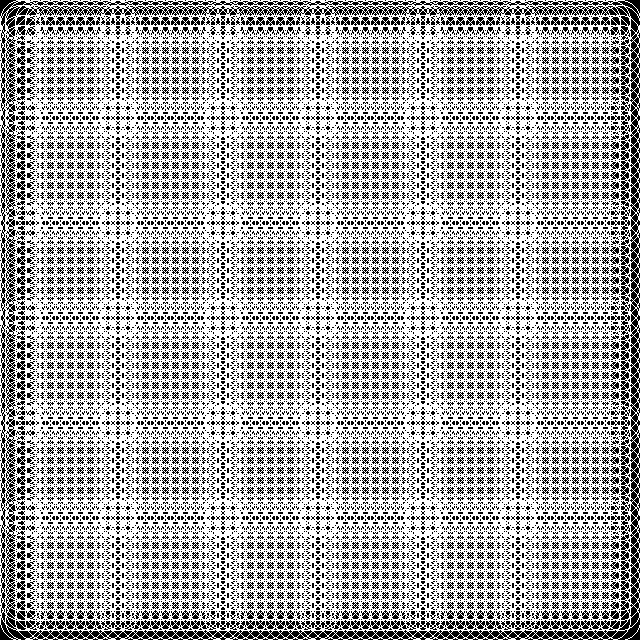

In [158]:
%%time
sz = config.sample_size
k = 5
retina_map_image = Image.new('RGBA', (sz * k, sz * k), color='black')
retina_map_draw = ImageDraw.Draw(retina_map_image)

for _, row in SENSOR_INSTANCES_INFO.iterrows():
    center_x = k * row.x_center
    center_y = k * row.y_center
    radius = k * row.radius
    retina_map_draw.circle((center_x, center_y), radius, width=1, outline=200)

retina_map_image

In [159]:
SENSOR_PATCH_COORDS = []

for _, row in SENSOR_INSTANCES_INFO.iterrows():
    x_offset = row.x_offset
    y_offset = row.y_offset
    size = row['size']

    for i in range(size):
        y = (y_offset + i) * config.sample_size
        stride_coords = np.arange(y + x_offset, y + x_offset + size)
        SENSOR_PATCH_COORDS.append(stride_coords)

SENSOR_PATCH_COORDS = np.array(SENSOR_PATCH_COORDS)

In [160]:
def get_image_patches_for_sensor_instances(images_matrix):
    assert images_matrix.ndim == 2, images_matrix.ndim
    assert images_matrix.shape[1] == config.sample_size ** 2, images_matrix.shape[1]
    images_count = images_matrix.shape[0]
    # Result is 3d-tensor: 1 dim - image, 2 dim - patch no, 3 dim - patch itself (pixels)
    return np.take(images_matrix, SENSOR_PATCH_COORDS, axis=1).reshape(images_count, -1, SENSOR_RECEPTIVE_FIELD_SQUARE)

# sequence_images

In [541]:
# Returns matrix of sense_vectors (one row = sense_vector for each image in images_matrix)
# Each elem in sense_vector describes sensor state of each sensor instance (-1 if sensor instance is not activated)
def sense_images(images_matrix):
    MINIMAL_ILLUMINATION_ABS_LEVEL = 255 * 0.1
    MINIMAL_ILLUMINATION_DIFF_DB = 2 # dB
    MINIMAL_ILLUMINATION_DIFF_RATIO = pow(10, MINIMAL_ILLUMINATION_DIFF_DB/20)
    MINIMAL_PLUS_MINUS_DISTR_REL_DIFF = 0.9
    
    assert images_matrix.ndim == 2
    images_count = images_matrix.shape[0]
    images_patches = get_image_patches_for_sensor_instances(images_matrix) # array of matrices: image no -> matrix with patches as row vectors
    
    mean_luminiscene_in_patches = images_patches.mean(axis=2) # matrix where each row = avg of luminisnece in each patch of an image
    mean_images_patches = images_patches.reshape(-1, SENSOR_RECEPTIVE_FIELD_SQUARE).T - mean_luminiscene_in_patches.ravel()
    mean_images_patches = mean_images_patches.T.reshape(images_count, -1, SENSOR_RECEPTIVE_FIELD_SQUARE).transpose(0, 2, 1)
    # mean_images_patches is an array of matrices: image no -> matrix with mean-centered patches as column vectors
    
    images_patches = images_patches.transpose(0, 2, 1) # array of matrices: image no -> matrix with patches as column vectors
    assert images_patches.shape == mean_images_patches.shape
    
    abs_illum_level_pos = (SENSOR_STATES_POS @ images_patches).transpose(0, 2, 1)
    abs_illum_level_neg = (SENSOR_STATES_NEG @ images_patches).transpose(0, 2, 1)
    rel_illum_level_pos = (SENSOR_STATES_POS @ xp.where(mean_images_patches > 0, +1, 0)).transpose(0, 2, 1) # for +/- tally
    rel_illum_level_neg = (SENSOR_STATES_NEG @ xp.where(mean_images_patches < 0, -1, 0)).transpose(0, 2, 1)  # for +/- tally
    
    assert abs_illum_level_pos.shape == (images_count, SENSORS_COUNT, SENSOR_STATES_COUNT), abs_illum_level_pos.shape
    assert abs_illum_level_neg.shape == abs_illum_level_pos.shape
    assert rel_illum_level_pos.shape == abs_illum_level_pos.shape
    assert rel_illum_level_neg.shape == abs_illum_level_pos.shape
    
    sense_vectors = []
    # For each patch in image we detect likelihood of activation of sensor in one of its (sensor's) state.
    # If we have some state (say some angle and some sweep), what is condition that given patch corresponds to this state?
    # Of course patch must be somewhat illuminated (regulated by SENSORS_POS) - this is to ensure that we don't get fooled by situation
    # when e.g. negative part is not illuminated (dot prod is 0) while positive part is illuminated very, very week (say dot prod is 5). Looks
    # like this is the reason why we don't hear very low frequencies or don't percieve low light - becase ratio get oversaturaed very quickly.
    # But the key point is that sum of pixels luminiscence can meet averaged criterion only when bright pixels are concentared in area covered by SENSORS_POS
    # and dark pixels are concentrated in area covered by SENSORS_NEG. Otherwise there will disbalance.
    # To detect this condition we can look at distribution of mean-centered patches: +pixels must reside in positive part, -pixels must reside in negative part.
    # To restassure that +/- distribution of pixels actually corresponds to detectable diff in illumination we also need to compare
    # absolute illumination on positive and negative part
    for ailp_i, ailn_i, rilp_i, riln_i in zip(abs_illum_level_pos, abs_illum_level_neg, rel_illum_level_pos, rel_illum_level_neg): # Per image cycle
        # ailp_i and ailn_i both are matrices N(patches count) x M(count of sensor states)
        shape_save = ailp_i.shape
    
        # MAC {0, 1}
        # Illumination level on positive area must exceed lower threshold (sensor must be somewhat illuminated)
        # abs_illumination_scores = matrix of N(patches count), columns - 0/1 if patch is minimally illuminated according to given sensor's state
        abs_illumination_scores = ailp_i > MINIMAL_ILLUMINATION_ABS_LEVEL * SENSOR_STATE_AREAS_POS
    
        # MAC {0, 1}
        # Illumination level on positive part must distinguishably exceed illumination level of negative part
        ailn_i += 1e-6 # to get rid of possible division by zero errors
        ailp_i = ailp_i / SENSOR_STATE_AREAS_POS
        ailn_i = ailn_i / SENSOR_STATE_AREAS_NEG
        diff_abs_illumination_scores = xp.abs(ailp_i.ravel() / ailn_i.ravel())
        diff_abs_illumination_scores = diff_abs_illumination_scores >= MINIMAL_ILLUMINATION_DIFF_RATIO
        # diff_abs_illumination_scores = matrix of N(patches count), columns - 0/1 if patch is illuminated more on positive part than on negative
        diff_abs_illumination_scores = diff_abs_illumination_scores.reshape(shape_save)
    
        # Score {0, [MINIMAL_PLUS_MINUS_DISTR_REL_DIFF...1]}
        # Tally concentration of +/- pixels on positive/negative side and compare against theirs areas. 
        # For sensors with proper distribution ratio will be around 1 for each of the scores.
        # *concentration_scores = matrix of N(patches count), columns - [0...1] how well pixels in patch are distributed according to given sensor's state
        pluses_concentration_scores = rilp_i / SENSOR_STATE_AREAS_POS
        # assert xp.all((pluses_concentration_scores >= 0) & (pluses_concentration_scores <= 1)) # comment for production (to speed up)
        mask = (pluses_concentration_scores < MINIMAL_PLUS_MINUS_DISTR_REL_DIFF)
        pluses_concentration_scores = xp.where(mask, 0, pluses_concentration_scores)
    
        minuses_concentration_scores = riln_i / SENSOR_STATE_AREAS_NEG
        # assert xp.all((minuses_concentration_scores >= 0) & (minuses_concentration_scores <= 1)) # comment for production (to speed up)
        mask = (minuses_concentration_scores < MINIMAL_PLUS_MINUS_DISTR_REL_DIFF)
        minuses_concentration_scores = xp.where(mask, 0, minuses_concentration_scores)
        
        # sense_matrix = matrix of N(patches count), columns - 0/1 if all three conditions meet for given sensor state
        sense_matrix = (abs_illumination_scores.astype(float) + diff_abs_illumination_scores.astype(float) + pluses_concentration_scores + minuses_concentration_scores)
        min_score = 1 + 1 + (MINIMAL_PLUS_MINUS_DISTR_REL_DIFF * 2)
        sense_vector = xp.where(xp.any(sense_matrix > min_score, axis=1), xp.argmax(sense_matrix, axis=1), -1)
        sense_vectors.append(sense_vector)
    
    return xp.vstack(sense_vectors)

In [677]:
# Returns (altitude_map, df_sensor_instances) for sense_vector
def get_altitude_map(sense_vector):
    ALTITUDE_EXTEND_BY = 5 # number of new intermediate cells for each side of 2x2 rect, e.g. 3x3 becomes 13x13 if altitude_extend_by is 5
    MAX_LANDING_STEPS = 1000
    MAX_ALTITUDE_THRESHOLD = 2
    
    assert sense_vector.shape[0] == len(SENSOR_INSTANCES_INFO)
    sensor_instance_inds = np.argwhere(sense_vector != -1).ravel()
    sensor_state_inds = np.take(sense_vector, sensor_instance_inds)
    assert sensor_instance_inds.shape[0] == sensor_state_inds.shape[0]
    df_sensor_instances_raw = pd.DataFrame({'sensor_instance_ind': sensor_instance_inds, 'sensor_state_ind': sensor_state_inds})
    df_sensor_instances_raw = df_sensor_instances_raw.merge(SENSOR_STATES_INFO, how='left', left_on='sensor_state_ind', right_index=True)
    df_sensor_instances_raw = df_sensor_instances_raw.merge(SENSOR_INSTANCES_INFO, how='left', left_on='sensor_instance_ind', right_index=True)

    # Lo-resolution altitude map
    altitude_map_lores = np.zeros((config.sample_size, config.sample_size))

    for si in df_sensor_instances_raw.itertuples():
        sensor_state = SENSOR_STATES[si.sensor_state_ind]
        size = si.size
        altitude_map_lores[si.y_offset:si.y_offset + size, si.x_offset:si.x_offset + size] += sensor_state.reshape(size, size)
    
    altitude_map_lores_mask = np.full_like(altitude_map_lores, np.min(altitude_map_lores), dtype='i')
    
    for si in df_sensor_instances_raw.itertuples():
        altitude_map_lores_mask[si.y_offset:si.y_offset + size, si.x_offset:si.x_offset + size] = 0
    
    altitude_map_lores += altitude_map_lores_mask
    altitude_map_lores = altitude_map_lores.astype('i')

    # Enhance lo-resolution altitude map by interpolating. This is to develop low altitude areas which are 
    # hidden beyond patches like [[-4, -5], [3, 4]]
    altitude_lores_to_hires_translate_factor = (ALTITUDE_EXTEND_BY + 1)
    altitude_map_hires_size = (config.sample_size - 1) * altitude_lores_to_hires_translate_factor + 1
    altitude_map_hires = np.zeros((altitude_map_hires_size, altitude_map_hires_size), dtype='f')
    patch_hires_shape = (2 + ALTITUDE_EXTEND_BY, 2 + ALTITUDE_EXTEND_BY)
    ii, jj = np.mgrid[0:patch_hires_shape[0], 0:patch_hires_shape[1]]
    patch_hires_indices = np.array(list(zip(ii.ravel(), jj.ravel())))
    
    for i in range(altitude_map_lores.shape[0] - 1):
        for j in range(altitude_map_lores.shape[1] - 1):
            patch = altitude_map_lores[i:i+2, j:j+2].astype(float)
    
            if patch[0,0] == patch[0,1] and patch[0,1] == patch[1,0] and patch[1,0] == patch[1,1]:
                patch_hires = patch[0,0]
            else:
                interp = RegularGridInterpolator(([0, patch_hires_shape[0] - 1], [0, patch_hires_shape[1] - 1]), patch)
                patch_hires = interp(patch_hires_indices).reshape(patch_hires_shape)
                
            i_hires = i * altitude_lores_to_hires_translate_factor
            j_hires = j * altitude_lores_to_hires_translate_factor
            altitude_map_hires[i_hires:i_hires+patch_hires_shape[0], j_hires:j_hires+patch_hires_shape[1]] = patch_hires

    # Reposition sensor instances so they occur in a valley with low absolute altitude. Some of the sensor instances will get discarded
    landed_centers = defaultdict(list)

    for si in df_sensor_instances_raw.itertuples():
        x_center_land = si.x_center * altitude_lores_to_hires_translate_factor
        y_center_land = si.y_center * altitude_lores_to_hires_translate_factor
        altitude = altitude_map_hires[y_center_land, x_center_land]
    
        if np.abs(altitude) > 1:
            travel_point = complex(x_center_land, y_center_land)
            direction = -1 if altitude < 0 else +1
            
            for i in range(MAX_LANDING_STEPS):
                travel_point += direction * si.normal_vec
                new_x_center_land = np.round(travel_point.real, decimals=0).astype(int)
                new_y_center_land = np.round(travel_point.imag, decimals=0).astype(int)
                new_altitude = np.abs(altitude_map_hires[new_y_center_land, new_x_center_land])
    
                if new_altitude <= altitude:
                    altitude = new_altitude
                    x_center_land = new_x_center_land
                    y_center_land = new_y_center_land
                else:
                    break
            else:
                assert False
    
        landed_centers['x_center_new'].append(x_center_land)
        landed_centers['y_center_new'].append(y_center_land)
        landed_centers['x_center_orig'].append(int(x_center_land / altitude_lores_to_hires_translate_factor))
        landed_centers['y_center_orig'].append(int(y_center_land / altitude_lores_to_hires_translate_factor))
        landed_centers['altitude_new'].append(altitude)
    
    df_sensor_instances = df_sensor_instances_raw.copy()
    
    for col_name, values in landed_centers.items():
        df_sensor_instances[col_name] = values
    
    df_sensor_instances.drop(['x_center', 'y_center', 'x_offset', 'y_offset', 'bounds_rect', 'normal_vec', 'sweep1_vec', 'sweep2_vec', 'size'], axis=1, inplace=True)
    df_sensor_instances.rename({'x_center_new': 'x_center', 'y_center_new': 'y_center', 'altitude_new': 'altitude'}, axis=1, inplace=True, errors='raise')
    df_sensor_instances = df_sensor_instances.loc[np.abs(df_sensor_instances.altitude) < MAX_ALTITUDE_THRESHOLD]
    df_sensor_instances['x'] = df_sensor_instances.x_center.astype(str) + ',' + df_sensor_instances.y_center.astype(str)
    df_sensor_instances.drop_duplicates(subset=['x'], inplace=True)
    return (altitude_map_hires, df_sensor_instances)

In [678]:
def discover_raw_sequences(df_sensor_instances, altitude_map):
    sensor_instance_map = {}
    sensor_instance_ind_dict = {}
    
    for si in df_sensor_instances.itertuples():
        sensor_instance_map[si.y_center, si.x_center] = si
        sensor_instance_ind_dict[int(si.Index)] = si
    
    unsorted_sensor_instance_inds = set(map(lambda si: si.Index, sensor_instance_map.values()))
    raw_sequences = {} # start_sensor_inst_index -> sensor_inst_chains
    
    while unsorted_sensor_instance_inds:
        # choose random sensor instance to start from
        start_sensor_inst_index = unsorted_sensor_instance_inds.pop()
        start_sensor_inst = sensor_instance_ind_dict[start_sensor_inst_index]
        
        wave_front_que = deque([(int(start_sensor_inst.y_center), int(start_sensor_inst.x_center))])
        wave_front_map = np.full_like(altitude_map, -1, dtype='i')
        wave_front_map[wave_front_que[0]] = start_sensor_inst.Index
        wave_front_touched = set([wave_front_que[0]])
        
        sensor_inst_chains = {} # key - last element in chain of sensor instances, value - chain itself
        
        # LOG(f'Starting countour from {start_sensor_inst_index} (of {len(unsorted_sensor_instance_inds)})')
        
        while wave_front_que:
            # Visit point on top of the wave_front
            wave_front_point = wave_front_que.popleft()
            wave_front_sensor_inst_ind = wave_front_map[wave_front_point]
            wave_front_map[wave_front_point] = -1
            assert wave_front_sensor_inst_ind > -1
            # LOG(f'Visiting {wave_front_point} (si={wave_front_sensor_inst_ind}) (of {len(wave_front_que)})')
        
            si = sensor_instance_map.get(wave_front_point, None)
        
            if not si is None and si.Index != wave_front_sensor_inst_ind:
                # New sensor instance discovered! Link with the previous one, ...
                sensor_inst_chain = sensor_inst_chains.pop(wave_front_sensor_inst_ind, [wave_front_sensor_inst_ind])
                sensor_inst_chain.append(si.Index)
                assert not si.Index in sensor_inst_chains, f'{si.Index} in sensor_inst_chains'
                sensor_inst_chains[si.Index] = sensor_inst_chain
                
                # LOG(f'New si encountered: {si.Index}, linked after {wave_front_sensor_inst_ind}')
                wave_front_sensor_inst_ind = si.Index
                # ... and adjust adjacent wave front points to account for new sensor instance
                # (adjacency criteria enables coexisting of separate (disjoint) wave fronts on a map)
                adjust_stack = [wave_front_point]
                adjust_touched = set([wave_front_point])
        
                while adjust_stack:
                    adjust_point = adjust_stack.pop()
        
                    for rel_ij in [[-1, -1], [-1, 0], [-1, 1], [0, -1], [0, 1], [1, -1], [1, 0], [1, 1]]:
                        ij = int(adjust_point[0] + rel_ij[0]), int(adjust_point[1] + rel_ij[1])
                
                        if ij[0] < 0 or ij[1] < 0 or ij[0] >= wave_front_map.shape[0] or ij[1] >= wave_front_map.shape[1]:
                            continue
                        elif wave_front_map[ij] == -1:
                            continue
                        elif ij in adjust_touched:
                            continue
        
                        # LOG(f'Adjusting {ij} (si={wave_front_map[ij]}) to si={si.Index}')
                        wave_front_map[ij] = si.Index
                        adjust_stack.append(ij)
                        adjust_touched.add(ij)
        
            # Plan further spread of the wave front
            for rel_ij in [[-1, -1], [-1, 0], [-1, 1], [0, -1], [0, 1], [1, -1], [1, 0], [1, 1]]:
                ij = int(wave_front_point[0] + rel_ij[0]), int(wave_front_point[1] + rel_ij[1])
                # LOG(f'... spread, checking coord {rel_ij} {ij}')
        
                if ij[0] < 0 or ij[1] < 0 or ij[0] >= altitude_map.shape[0] or ij[1] >= altitude_map.shape[1]:
                    # LOG(f'... spread, {ij} out of boundaries')
                    continue
                elif np.abs(altitude_map[ij]) >= 2: # coord_ij falls out of valley
                    # LOG(f'... spread, {ij} has bad altitude {altitude_map[ij]}')
                    continue
                elif ij in wave_front_touched:
                    # LOG(f'... spread, {ij} already touched ({len(wave_front_touched)})')
                    continue
        
                wave_front_touched.add(ij)
                wave_front_que.append(ij)
                wave_front_map[ij] = wave_front_sensor_inst_ind
                # LOG(f'... new wave front point {wave_front_que[-1]} (si={wave_front_sensor_inst_ind})')
    
        raw_sequences[start_sensor_inst_index] = sensor_inst_chains
        # Collect all sensor instances encountered during this run and account them as sorted
        sorted_sensor_instance_inds = set(itertools.chain.from_iterable(sensor_inst_chains.values()))
        unsorted_sensor_instance_inds -= sorted_sensor_instance_inds

    return raw_sequences

In [679]:
def weave_raw_sequences(df_sensor_instances, raw_sequences):
    sensor_instance_ind_to_xy = {}
    
    for si in df_sensor_instances.itertuples():
        sensor_instance_ind_to_xy[int(si.Index)] = (si.x_center_orig, si.y_center_orig)
        
    sequences = []
        
    for sensor_inst_chains in raw_sequences.values():
        # Our goal is to find two longest subsequence which start from the same si and clue them together. 
        # Usually this would be two subsequences starting from start_sensor_inst_index.
        # This way we would get longest serial sequence of traverse
        subsequences = []
        
        for chain_index, chain in enumerate(sensor_inst_chains.values()):
            chains_wo_chain_index = map(lambda v: v[1], filter(lambda v: v[0] != chain_index, enumerate(sensor_inst_chains.values())))
            chains_dict = defaultdict(list)
            for v in chains_wo_chain_index: chains_dict[v[0]].append(v)
            
            subsequences.append([])
            branch_stack = [(chain, 0, len(subsequences) - 1)]
            # LOG(f'Starting new subsequence #{len(subsequences) - 1}, {chain[0]}')
        
            while branch_stack:
                chain, chain_elem_index, subseq_index = branch_stack.pop()
                subseq = subsequences[subseq_index]
                # LOG(f'Weaving subsequence #{subseq_index}, {chain[chain_elem_index]}')
                
                for i in range(chain_elem_index, len(chain)):
                    v = chain[i]
                    subseq.append(v)
                    # LOG(f'... adding {chain[i]}, subseq len={len(subseq)}, subseq[:3]={subseq[:3]}, subseq[-3:]={subseq[-3:]}')
        
                    if v in chains_dict:
                        # LOG(f'... branch point detected')
                        branch_stack.append((chain, i + 1, subseq_index)) # continue sequence by following current chain
    
                        # Start new subsequences from new chain
                        for branch_chain in chains_dict[v]:
                            new_subseq = subseq.copy()
                            subsequences.append(new_subseq)
                            branch_stack.append((branch_chain, 1, len(subsequences) - 1)) # create new sequence and follow new chain
                            # LOG(f'... branching new subsequence #{len(subsequences) - 1}, {branch_chain[1]}')
                            
                        break
    
        longest_sequence = []
    
        if not subsequences:
            continue
        elif len(subsequences) == 1:
            longest_subsequence = subsequences[0]
        else:
            for ii in itertools.combinations(range(len(subsequences)), 2):
                subseq1 = subsequences[ii[0]]
                subseq2 = subsequences[ii[1]]
                prefix_i = 0
        
                while prefix_i < min(len(subseq1), len(subseq2)) and subseq1[prefix_i] == subseq2[prefix_i]:
                    prefix_i += 1
        
                if prefix_i == 0:
                    # No common prefix, cant clue these two subseqs
                    continue
        
                sequence = list(reversed(subseq1[prefix_i:])) + [subseq1[prefix_i - 1]] + subseq2[prefix_i:]
        
                if len(sequence) > len(longest_sequence):
                    longest_sequence = sequence
    
        if longest_sequence:
            sequence_as_xy = list(map(sensor_instance_ind_to_xy.get, longest_sequence))
            sequences.append(sequence_as_xy)

    return sequences

CPU times: user 2.35 s, sys: 112 ms, total: 2.46 s
Wall time: 893 ms



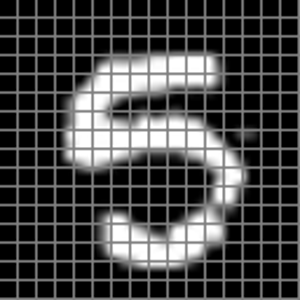
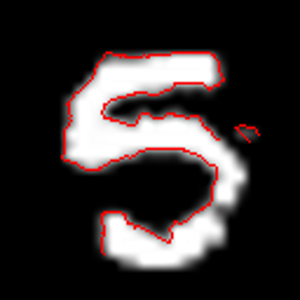

In [687]:
%%time
image_indices = RNG.choice(len(x_train), 100)
image_indices = [1961]
# 45917 - то ли 9, то ли что. Вообще непонятно - всё размыто
# 1199 (2) - 50% не разобрали
# 1946 (7) - 50% не разобрали
# 26405 (9) - 30% не разобрали
# 12627 (8) - 50% не разобрали
images = []
captions = []

for image_index in image_indices:
    img_data = x_train[image_index]
    
    with Image.frombytes('L', size=(28, 28), data=img_data) as img:
        img = img.resize((config.sample_size, config.sample_size))
        images.append(np.array(img).ravel())
        captions.append(f'{image_index}, {y_train[image_index]}')

images_matrix = xp_array_to_gpu(np.vstack([images]))
sense_vectors = sense_images(images_matrix)
assert sense_vectors.shape[0] == len(images)
sequences_list = []

for sense_vector in sense_vectors:
    altitude_map, df_sensor_instances = get_altitude_map(sense_vector)
    raw_sequences = discover_raw_sequences(df_sensor_instances, altitude_map)
    sequences = weave_raw_sequences(df_sensor_instances, raw_sequences)
    sequences_list.append(sequences)

seq_images = []

for image, sequences in zip(images, sequences_list):
    image_pil = Image.frombytes('L', size=(config.sample_size, config.sample_size), data=image)
    image_pil = image_pil.convert('RGB')
    draw = ImageDraw.Draw(image_pil)

    for seq in sequences:
        for pt_from, pt_to in zip(seq, seq[1:]):
            draw.line([pt_from[0], pt_from[1], pt_to[0], pt_to[1]], width=1, fill='red')

    seq_images.append(image_pil)
    
all_images = itertools.chain.from_iterable(zip(map(lambda i: lay_grid(matrix_to_image(i), 8), images), seq_images))
all_images = list(map(lambda i: i.resize((300, 300)), all_images))
all_captions = list(itertools.chain.from_iterable(itertools.zip_longest(captions, [], fillvalue='')))
display_images_grid(all_images, captions=all_captions, col_count=4)

# Spare parts

In [166]:
a = np.arange(16).reshape(4,4)
a2 = a * (-2)
a2[3] += 1
a, a2

(array([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11],
        [12, 13, 14, 15]]),
 array([[  0,  -2,  -4,  -6],
        [ -8, -10, -12, -14],
        [-16, -18, -20, -22],
        [-23, -25, -27, -29]]))

In [167]:
# Get patches 2x2 from upper left and bottom right corners of both a and a2
x = np.take(np.vstack([a.ravel(), a2.ravel()]), [[0, 1], [4, 5], [10, 11], [14, 15]], axis=1).reshape(2, -1, 4)
x

array([[[  0,   1,   4,   5],
        [ 10,  11,  14,  15]],

       [[  0,  -2,  -8, -10],
        [-20, -22, -27, -29]]])

In [168]:
# Get mean of each patch
x.mean(axis=2)

array([[  2.5,  12.5],
       [ -5. , -24.5]])

In [169]:
# Recalculate patches against their mean and turn to shape: images(2), patches(2), pixels(4)
y = x.reshape(-1, 4).T - x.mean(axis=2).ravel()
y.T.reshape(2, -1, 4).transpose(0, 2, 1)

array([[[-2.5, -2.5],
        [-1.5, -1.5],
        [ 1.5,  1.5],
        [ 2.5,  2.5]],

       [[ 5. ,  4.5],
        [ 3. ,  2.5],
        [-3. , -2.5],
        [-5. , -4.5]]])

In [186]:
image = np.empty((config.sample_size, config.sample_size), dtype='b')
image2 = np.empty((config.sample_size, config.sample_size), dtype='b')
images_matrix = np.vstack([image.ravel(), image2.ravel()])
images_count = images_matrix.shape[0]
images_patches = get_image_patches_for_sensor_instances(images_matrix)
images_patches.shape

(2, 4096, 64)

In [ ]:
mean_luminiscene_in_patches = images_patches.mean(axis=2) # matrix where each row = avg of luminisnece in each patch of an image
mean_luminiscene_in_patches.shape

In [ ]:
images_patches = images_patches.reshape(-1, SENSOR_RECEPTIVE_FIELD_SQUARE).T - mean_luminiscene_in_patches.ravel()
images_patches = images_patches.T.reshape(images_count, -1, SENSOR_RECEPTIVE_FIELD_SQUARE).transpose(0, 2, 1)
images_patches.shape

In [688]:
images = []

for _ in range(1):
    image_index = RNG.choice(len(x_train))
    # image_index = 58980 # 4 with isthmus (ok)
    # image_index = 38174 # 3 with isthmus (ok)
    # image_index = 4900 # 1 unclosed right side (ok)
    # image_index = 35616 # 4 unclosed top right side (ok)
    # image_index = 8527 # 0 (ok)
    # image_index = 12543 # 4 (ok)
    # image_index = 59746 # 1 or 7 (ok)
    # image_index = 13952 # 2 with loop (ok)
    # image_index = 56318 # 0 (ok)
    # image_index = 55199 # 2 with fat filled loop (ok)
    # image_index = 46780 # 1 (ok)
    # image_index = 4416 # 5 with separated hat (ok)
    # image_index = 1199 # 2 big fat
    # image_index = 26405 # 9 (~20% not traced)
    # image_index = 12627 
    # image_index = 1946 # 7 with isthmus. Part of 7 is not sequenced due to algo limitation - we only allow 2 branching of primary chains
    # image_index = 52002 # 1 with isthmus (half not sequenced)
    # image_index = 12603 # 2
    # image_index = 57924 # 2
    # image_index = 9322
    image_index = 1961
    
    print(image_index)
    img_data = x_train[image_index]
    
    with Image.frombytes('L', size=(28, 28), data=img_data) as img:
        img = img.resize((config.sample_size, config.sample_size))
        images.append(np.array(img).ravel())

images_matrix = xp_array_to_gpu(np.vstack([images]))

1961


In [689]:
%%time
MINIMAL_ILLUMINATION_ABS_LEVEL = 255 * 0.1
MINIMAL_ILLUMINATION_DIFF_DB = 2 # dB
MINIMAL_ILLUMINATION_DIFF_RATIO = pow(10, MINIMAL_ILLUMINATION_DIFF_DB/20)
MINIMAL_PLUS_MINUS_DISTR_REL_DIFF = 0.9

images_count = images_matrix.shape[0]
images_patches = get_image_patches_for_sensor_instances(images_matrix) # array of matrices: image no -> matrix with patches as row vectors

mean_luminiscene_in_patches = images_patches.mean(axis=2) # matrix where each row = avg of luminisnece in each patch of an image
mean_images_patches = images_patches.reshape(-1, SENSOR_RECEPTIVE_FIELD_SQUARE).T - mean_luminiscene_in_patches.ravel()
mean_images_patches = mean_images_patches.T.reshape(images_count, -1, SENSOR_RECEPTIVE_FIELD_SQUARE).transpose(0, 2, 1)
# mean_images_patches is an array of matrices: image no -> matrix with mean-centered patches as column vectors

images_patches = images_patches.transpose(0, 2, 1) # array of matrices: image no -> matrix with patches as column vectors
assert images_patches.shape == mean_images_patches.shape

abs_illum_level_pos = (SENSOR_STATES_POS @ images_patches).transpose(0, 2, 1)
abs_illum_level_neg = (SENSOR_STATES_NEG @ images_patches).transpose(0, 2, 1)
rel_illum_level_pos = (SENSOR_STATES_POS @ xp.where(mean_images_patches > 0, +1, 0)).transpose(0, 2, 1) # for +/- tallying
rel_illum_level_neg = (SENSOR_STATES_NEG @ xp.where(mean_images_patches < 0, -1, 0)).transpose(0, 2, 1)  # for +/- tallying

assert abs_illum_level_pos.shape == (images_count, SENSORS_COUNT, SENSOR_STATES_COUNT), abs_illum_level_pos.shape
assert abs_illum_level_neg.shape == abs_illum_level_pos.shape
assert rel_illum_level_pos.shape == abs_illum_level_pos.shape
assert rel_illum_level_neg.shape == abs_illum_level_pos.shape

sense_vectors = []
# For each patch in image we detect likelihood of activation of sensor in one of its (sensor's) state.
# If we have some state (say some angle and some sweep), what is condition that given patch corresponds to this state?
# Of course patch must be somewhat illuminated (regulated by SENSORS_POS) - this is to ensure that we don't get fooled by situation
# when e.g. negative part is not illuminated (dot prod is 0) while positive part is illuminated very, very week (say dot prod is 5). Looks
# like this is the reason why we don't hear very low frequencies or don't percieve low light - becase ratio get oversaturaed very quickly.
# But the key point is that sum of pixels luminiscence can meet averaged criterion only when bright pixels are concentared in area covered by SENSORS_POS
# and dark pixels are concentrated in area covered by SENSORS_NEG. Otherwise there will disbalance.
# To detect this condition we can look at distribution of mean-centered patches: +pixels must reside in positive part, -pixels must reside in negative part.
# To restassure that +/- distribution of pixels actually corresponds to detectable diff in illumination we also need to compare
# absolute illumination on positive and negative part
for ailp_i, ailn_i, rilp_i, riln_i in zip(abs_illum_level_pos, abs_illum_level_neg, rel_illum_level_pos, rel_illum_level_neg): # Per image cycle
    # ailp_i and ailn_i both are matrices N(patches count) x M(count of sensor states)
    shape_save = ailp_i.shape

    # MAC {0, 1}
    # Illumination level on positive area must exceed lower threshold (sensor must be somewhat illuminated)
    # abs_illumination_scores = matrix of N(patches count), columns - 0/1 if patch is minimally illuminated according to given sensor's state
    abs_illumination_scores = ailp_i > MINIMAL_ILLUMINATION_ABS_LEVEL * SENSOR_STATE_AREAS_POS

    # MAC {0, 1}
    # Illumination level on positive part must distinguishably exceed illumination level of negative part
    ailn_i += 1e-6 # to get rid of possible division by zero errors
    ailp_i = ailp_i / SENSOR_STATE_AREAS_POS
    ailn_i = ailn_i / SENSOR_STATE_AREAS_NEG
    diff_abs_illumination_scores = xp.abs(ailp_i.ravel() / ailn_i.ravel())
    diff_abs_illumination_scores = diff_abs_illumination_scores >= MINIMAL_ILLUMINATION_DIFF_RATIO
    # diff_abs_illumination_scores = matrix of N(patches count), columns - 0/1 if patch is illuminated more on positive part than on negative
    diff_abs_illumination_scores = diff_abs_illumination_scores.reshape(shape_save)

    # Score {0, [MINIMAL_PLUS_MINUS_DISTR_REL_DIFF...1]}
    # Tally concentration of +/- pixels on positive/negative side and compare against theirs areas. 
    # For sensors with proper distribution ratio will be around 1 for each of the scores.
    # *concentration_scores = matrix of N(patches count), columns - [0...1] how well pixels in patch are distributed according to given sensor's state
    pluses_concentration_scores = rilp_i / SENSOR_STATE_AREAS_POS
    assert xp.all((pluses_concentration_scores >= 0) & (pluses_concentration_scores <= 1)) # comment for production (to speed up)
    mask = (pluses_concentration_scores < MINIMAL_PLUS_MINUS_DISTR_REL_DIFF)
    pluses_concentration_scores = xp.where(mask, 0, pluses_concentration_scores)

    minuses_concentration_scores = riln_i / SENSOR_STATE_AREAS_NEG
    assert xp.all((minuses_concentration_scores >= 0) & (minuses_concentration_scores <= 1)) # comment for production (to speed up)
    mask = (minuses_concentration_scores < MINIMAL_PLUS_MINUS_DISTR_REL_DIFF)
    minuses_concentration_scores = xp.where(mask, 0, minuses_concentration_scores)
    
    # sense_matrix = matrix of N(patches count), columns - 0/1 if all three conditions meet for given sensor state
    sense_matrix = (abs_illumination_scores.astype(float) + diff_abs_illumination_scores.astype(float) + pluses_concentration_scores + minuses_concentration_scores)
    min_score = 1 + 1 + (MINIMAL_PLUS_MINUS_DISTR_REL_DIFF * 2)
    sense_vector = xp.where(xp.any(sense_matrix > min_score, axis=1), xp.argmax(sense_matrix, axis=1), -1)
    sense_vectors.append(sense_vector)

sense_vectors = xp.vstack(sense_vectors)

CPU times: user 1.06 s, sys: 119 ms, total: 1.18 s
Wall time: 109 ms


In [690]:
assert sense_vector.shape[0] == len(SENSOR_INSTANCES_INFO)
sensor_instance_inds = np.argwhere(sense_vector != -1).ravel()
sensor_state_inds = np.take(sense_vector, sensor_instance_inds)
assert sensor_instance_inds.shape[0] == sensor_state_inds.shape[0]
df_sensor_instances_raw = pd.DataFrame({'sensor_instance_ind': sensor_instance_inds, 'sensor_state_ind': sensor_state_inds})
df_sensor_instances_raw = df_sensor_instances_raw.merge(SENSOR_STATES_INFO, how='left', left_on='sensor_state_ind', right_index=True)
df_sensor_instances_raw = df_sensor_instances_raw.merge(SENSOR_INSTANCES_INFO, how='left', left_on='sensor_instance_ind', right_index=True)
df_sensor_instances_raw

,sensor_instance_ind,sensor_state_ind,normal,sweep,normal_vec,sweep1_vec,sweep2_vec,x_offset,y_offset,size,bounds_rect,x_center,y_center,radius
0,598,144,250,270,-0.342020-0.939693j,0.906308+0.422618j,-0.422618+0.906308j,41,17,8,"[41, 17, 48, 24]",45,21,4
1,599,149,260,270,-0.173648-0.984808j,0.819152+0.573576j,-0.573576+0.819152j,43,17,8,"[43, 17, 50, 24]",47,21,4
2,621,149,260,270,-0.173648-0.984808j,0.819152+0.573576j,-0.573576+0.819152j,85,17,8,"[85, 17, 92, 24]",89,21,4
3,660,134,230,270,-0.642788-0.766044j,0.996195+0.087156j,-0.087156+0.996195j,38,19,8,"[38, 19, 45, 26]",42,23,4
4,662,143,250,230,-0.342020-0.939693j,0.996195+0.087156j,-0.707107+0.707107j,41,19,8,"[41, 19, 48, 26]",45,23,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
719,3752,43,70,230,0.342020+0.939693j,-0.996195-0.087156j,0.707107-0.707107j,76,110,8,"[76, 110, 83, 117]",80,114,4
720,3753,33,50,230,0.642788+0.766044j,-0.965926+0.258819j,0.422618-0.906308j,78,110,8,"[78, 110, 85, 117]",82,114,4
721,3801,74,130,270,-0.642788+0.766044j,-0.087156-0.996195j,0.996195-0.087156j,47,112,8,"[47, 112, 54, 119]",51,116,4
722,3802,64,110,270,-0.342020+0.939693j,-0.422618-0.906308j,0.906308-0.422618j,49,112,8,"[49, 112, 56, 119]",53,116,4


In [691]:
%%time
altitude_map_lores = np.zeros((config.sample_size, config.sample_size))

for si in df_sensor_instances_raw.itertuples():
    sensor_state = SENSOR_STATES[si.sensor_state_ind]
    size = si.size
    altitude_map_lores[si.y_offset:si.y_offset + size, si.x_offset:si.x_offset + size] += sensor_state.reshape(size, size)

altitude_map_lores_mask = np.full_like(altitude_map_lores, np.min(altitude_map_lores), dtype='i')

for si in df_sensor_instances_raw.itertuples():
    altitude_map_lores_mask[si.y_offset:si.y_offset + size, si.x_offset:si.x_offset + size] = 0

altitude_map_lores += altitude_map_lores_mask
altitude_map_lores = altitude_map_lores.astype('i')

CPU times: user 22 ms, sys: 144 μs, total: 22.2 ms
Wall time: 21.6 ms


In [692]:
%%time
altitude_extend_by = 5 # number of new intermediate cells for each side of 2x2 rect, e.g. 3x3 becomes 13x13 if altitude_extend_by is 5
altitude_lores_to_hires_translate_factor = (altitude_extend_by + 1)
altitude_map_hires_size = (config.sample_size - 1) * altitude_lores_to_hires_translate_factor + 1
altitude_map_hires = np.zeros((altitude_map_hires_size, altitude_map_hires_size), dtype='f')
patch_hires_shape = (2 + altitude_extend_by, 2 + altitude_extend_by)
ii, jj = np.mgrid[0:patch_hires_shape[0], 0:patch_hires_shape[1]]
patch_hires_indices = np.array(list(zip(ii.ravel(), jj.ravel())))

for i in range(altitude_map_lores.shape[0] - 1):
    for j in range(altitude_map_lores.shape[1] - 1):
        patch = altitude_map_lores[i:i+2, j:j+2].astype(float)

        if patch[0,0] == patch[0,1] and patch[0,1] == patch[1,0] and patch[1,0] == patch[1,1]:
            patch_hires = patch[0,0]
        else:
            interp = RegularGridInterpolator(([0, patch_hires_shape[0] - 1], [0, patch_hires_shape[1] - 1]), patch)
            patch_hires = interp(patch_hires_indices).reshape(patch_hires_shape)
            
        i_hires = i * altitude_lores_to_hires_translate_factor
        j_hires = j * altitude_lores_to_hires_translate_factor
        altitude_map_hires[i_hires:i_hires+patch_hires_shape[0], j_hires:j_hires+patch_hires_shape[1]] = patch_hires

CPU times: user 555 ms, sys: 149 μs, total: 555 ms
Wall time: 555 ms



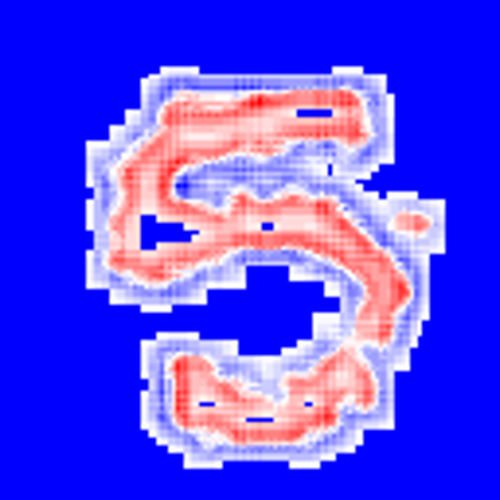
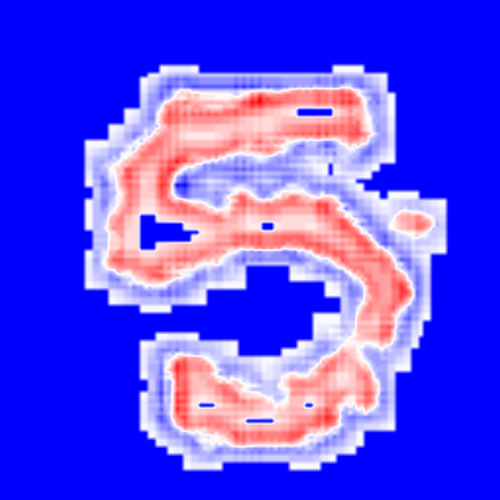

In [693]:
altitude_color_map = mpl.colormaps['bwr']
altitude_images = []
altitude_maps = [altitude_map_lores, altitude_map_hires]

for am in altitude_maps:
    image_pil = Image.new('RGB', size=(am.shape[0], am.shape[1]))
    draw = ImageDraw.Draw(image_pil)
    min_max_scaler = preprocessing.MinMaxScaler()
    altitude_map_scaled = min_max_scaler.fit_transform(am.reshape(-1, 1)).reshape(am.shape)

    for y in range(am.shape[0]):
        for x in range(am.shape[1]):
            color = altitude_color_map(altitude_map_scaled[y, x], bytes=True)
            draw.point((x, y), fill=color)

    altitude_images.append(image_pil)
    
display_images(list(map(lambda i: i.resize((500, 500)), altitude_images)))

In [694]:
landed_centers = defaultdict(list)

for si in df_sensor_instances_raw.itertuples():
    x_center_land = si.x_center * altitude_lores_to_hires_translate_factor
    y_center_land = si.y_center * altitude_lores_to_hires_translate_factor
    altitude = altitude_map_hires[y_center_land, x_center_land]

    if np.abs(altitude) > 1:
        travel_point = complex(x_center_land, y_center_land)
        direction = -1 if altitude < 0 else +1
        
        for i in range(100):
            travel_point += direction * si.normal_vec
            new_x_center_land = np.round(travel_point.real, decimals=0).astype(int)
            new_y_center_land = np.round(travel_point.imag, decimals=0).astype(int)
            new_altitude = np.abs(altitude_map_hires[new_y_center_land, new_x_center_land])

            if new_altitude <= altitude:
                altitude = new_altitude
                x_center_land = new_x_center_land
                y_center_land = new_y_center_land
            else:
                break
        else:
            assert False

    landed_centers['x_center_new'].append(x_center_land)
    landed_centers['y_center_new'].append(y_center_land)
    landed_centers['x_center_orig'].append(int(x_center_land / altitude_lores_to_hires_translate_factor))
    landed_centers['y_center_orig'].append(int(y_center_land / altitude_lores_to_hires_translate_factor))
    landed_centers['altitude_new'].append(altitude)

df_sensor_instances = df_sensor_instances_raw.copy()

for col_name, values in landed_centers.items():
    df_sensor_instances[col_name] = values

df_sensor_instances.drop(['x_center', 'y_center', 'x_offset', 'y_offset', 'bounds_rect', 'normal_vec', 'sweep1_vec', 'sweep2_vec', 'size'], axis=1, inplace=True)
df_sensor_instances.rename({'x_center_new': 'x_center', 'y_center_new': 'y_center', 'altitude_new': 'altitude'}, axis=1, inplace=True, errors='raise')
df_sensor_instances = df_sensor_instances.loc[np.abs(df_sensor_instances.altitude) < 2]
df_sensor_instances['x'] = df_sensor_instances.x_center.astype(str) + ',' + df_sensor_instances.y_center.astype(str)
df_sensor_instances.drop_duplicates(subset=['x'], inplace=True)
df_sensor_instances

,sensor_instance_ind,sensor_state_ind,normal,sweep,radius,x_center,y_center,x_center_orig,y_center_orig,altitude,x
5,663,143,250,230,4,282,138,47,23,1.000000e+00,"282,138"
14,672,152,270,180,4,384,138,64,23,-1.000000e+00,"384,138"
15,673,152,270,180,4,396,138,66,23,1.000000e+00,"396,138"
16,674,152,270,180,4,408,138,68,23,0.000000e+00,"408,138"
18,676,152,270,180,4,432,138,72,23,1.000000e+00,"432,138"
...,...,...,...,...,...,...,...,...,...,...,...
695,3683,46,80,130,4,421,680,70,113,2.222222e-01,"421,680"
696,3684,46,80,130,4,433,679,72,113,2.222222e-01,"433,679"
697,3685,46,80,130,4,445,680,74,113,5.555556e-01,"445,680"
698,3686,42,70,180,4,458,677,76,112,1.110223e-16,"458,677"


In [695]:
LOG.is_enabled = False

In [705]:
# %%time
sensor_instance_map = {}
sensor_instance_ind_dict = {}

for si in df_sensor_instances.itertuples():
    sensor_instance_map[si.y_center, si.x_center] = si
    sensor_instance_ind_dict[int(si.Index)] = si

unsorted_sensor_instance_inds = set(map(lambda si: si.Index, sensor_instance_map.values()))
unsorted_sensor_instance_inds = set([5])
raw_sequences = {} # start_sensor_inst_index -> sensor_inst_chains

while unsorted_sensor_instance_inds:
    # choose random sensor instance to start from
    start_sensor_inst_index = unsorted_sensor_instance_inds.pop()
    start_sensor_inst = sensor_instance_ind_dict[start_sensor_inst_index]
    assert start_sensor_inst.altitude < 2
    
    wave_front_que = deque([(int(start_sensor_inst.y_center), int(start_sensor_inst.x_center))])
    wave_front_map = np.full_like(altitude_map_hires, -1, dtype='i')
    wave_front_map[wave_front_que[0]] = start_sensor_inst.Index
    wave_front_touched = set([wave_front_que[0]])
    
    sensor_inst_chains = {} # key - last element in chain of sensor instances, value - chain itself
    
    LOG(f'Starting countour from {start_sensor_inst_index} (of {len(unsorted_sensor_instance_inds)})')
    
    while wave_front_que:
        # Visit point on top of the wave_front
        wave_front_point = wave_front_que.popleft()
        wave_front_sensor_inst_ind = int(wave_front_map[wave_front_point])
        wave_front_map[wave_front_point] = -1
        assert wave_front_sensor_inst_ind > -1
        LOG(f'Visiting {wave_front_point} (si={wave_front_sensor_inst_ind}) (of {len(wave_front_que)})')
    
        si = sensor_instance_map.get(wave_front_point, None)
    
        if not si is None and si.Index != wave_front_sensor_inst_ind:
            # New sensor instance discovered! Link with the previous one, ...
            sensor_inst_chain = sensor_inst_chains.pop(wave_front_sensor_inst_ind, [wave_front_sensor_inst_ind])
            sensor_inst_chain.append(si.Index)
            assert not si.Index in sensor_inst_chains, f'{si.Index} in sensor_inst_chains'
            sensor_inst_chains[si.Index] = sensor_inst_chain
            
            LOG(f'New si encountered: {si.Index}, linked after {wave_front_sensor_inst_ind}')
            wave_front_sensor_inst_ind = si.Index
            # ... and adjust adjacent wave front points to account for new sensor instance
            # (adjacency criteria enables coexisting of separate (disjoint) wave fronts on a map)
            adjust_stack = [wave_front_point]
            adjust_touched = set([wave_front_point])
    
            while adjust_stack:
                adjust_point = adjust_stack.pop()
    
                for rel_ij in [[-1, -1], [-1, 0], [-1, 1], [0, -1], [0, 1], [1, -1], [1, 0], [1, 1]]:
                    ij = int(adjust_point[0] + rel_ij[0]), int(adjust_point[1] + rel_ij[1])
            
                    if ij[0] < 0 or ij[1] < 0 or ij[0] >= wave_front_map.shape[0] or ij[1] >= wave_front_map.shape[1]:
                        continue
                    elif wave_front_map[ij] == -1:
                        continue
                    elif ij in adjust_touched:
                        continue
    
                    LOG(f'Adjusting {ij} (si={wave_front_map[ij]}) to si={si.Index}')
                    wave_front_map[ij] = si.Index
                    adjust_stack.append(ij)
                    adjust_touched.add(ij)
    
        # Plan further spread of the wave front
        for rel_ij in [[-1, -1], [-1, 0], [-1, 1], [0, -1], [0, 1], [1, -1], [1, 0], [1, 1]]:
            ij = int(wave_front_point[0] + rel_ij[0]), int(wave_front_point[1] + rel_ij[1])
            LOG(f'... spread, checking coord {rel_ij} {ij}')
    
            if ij[0] < 0 or ij[1] < 0 or ij[0] >= altitude_map_hires.shape[0] or ij[1] >= altitude_map_hires.shape[1]:
                LOG(f'... spread, {ij} out of boundaries')
                continue
            elif np.abs(altitude_map_hires[ij]) >= 2: # coord_ij falls out of valley
                LOG(f'... spread, {ij} has bad altitude {altitude_map_hires[ij]}')
                continue
            elif ij in wave_front_touched:
                LOG(f'... spread, {ij} already touched ({len(wave_front_touched)})')
                continue
    
            wave_front_touched.add(ij)
            wave_front_que.append(ij)
            wave_front_map[ij] = wave_front_sensor_inst_ind
            LOG(f'... new wave front point {wave_front_que[-1]} (si={wave_front_sensor_inst_ind})')

    raw_sequences[start_sensor_inst_index] = sensor_inst_chains
    # Collect all sensor instances encountered during this run and account them as sorted
    sorted_sensor_instance_inds = set(itertools.chain.from_iterable(sensor_inst_chains.values()))
    unsorted_sensor_instance_inds -= sorted_sensor_instance_inds

In [706]:
raw_sequences.keys()

dict_keys([5])

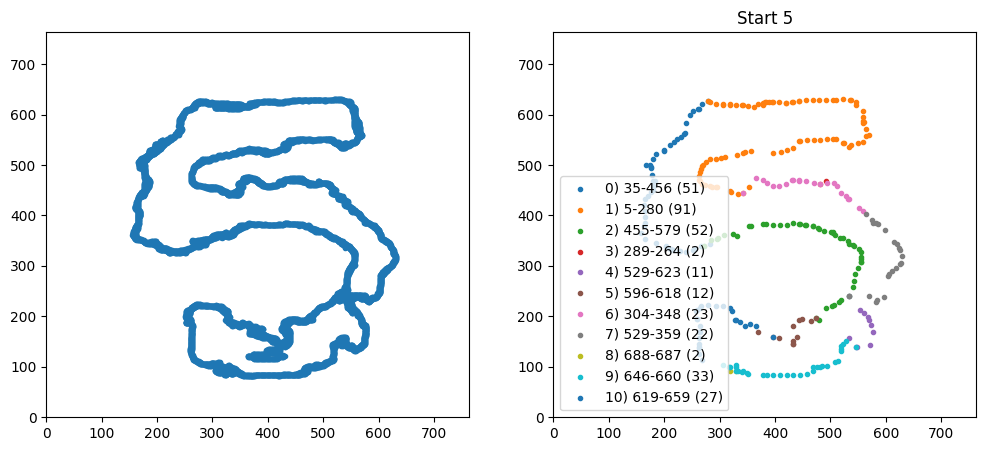

In [707]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.ylim(0, altitude_map_hires.shape[0])
plt.xlim(0, altitude_map_hires.shape[0])
pts = np.array(list(wave_front_touched))
plt.scatter(pts[:,1], altitude_map_hires.shape[0] - pts[:,0], marker='.')

plt.subplot(1, 2, 2)
plt.ylim(0, altitude_map_hires.shape[0])
plt.xlim(0, altitude_map_hires.shape[0])
plt.title(f'Start {start_sensor_inst_index}')

for i, chain in enumerate(sensor_inst_chains.values()):
    pts = np.array(list(map(lambda n: tuple(df_sensor_instances.loc[n][['x_center', 'y_center']]), chain)))
    plt.scatter(pts[:,0], altitude_map_hires.shape[0] - pts[:,1], marker='.', label=f'{i}) {chain[0]}-{chain[-1]} ({len(chain)})')
    
plt.legend()
plt.show()

In [583]:
list(map(lambda v: f'{v[0]} -> {len(v[1])}', chains_dict.items()))

['232 -> 2', '7 -> 1']

In [569]:
chain_index = -1

In [570]:
list(map(lambda v: f'{v[0]} -> {len(v)}', sensor_inst_chains.values()))

[]

In [571]:
list(itertools.combinations(range(6), 2))

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (2, 3),
 (2, 4),
 (2, 5),
 (3, 4),
 (3, 5),
 (4, 5)]

In [623]:
%%time
sensor_instance_ind_to_xy = {}

for si in df_sensor_instances.itertuples():
    sensor_instance_ind_to_xy[int(si.Index)] = (si.x_center_orig, si.y_center_orig)

sequences = []
    
for sensor_inst_chains in raw_sequences.values():
    # Our goal is to find two longest subsequence which start from the same si and clue them together. 
    # Usually this would be two subsequences starting from start_sensor_inst_index.
    # This way we would get longest serial sequence of traverse
    subsequences = []
    
    for chain_index, chain in enumerate(sensor_inst_chains.values()):
        chains_wo_chain_index = map(lambda v: v[1], filter(lambda v: v[0] != chain_index, enumerate(sensor_inst_chains.values())))
        chains_dict = defaultdict(list)
        for v in chains_wo_chain_index: chains_dict[v[0]].append(v)
        
        subsequences.append([])
        branch_stack = [(chain, 0, len(subsequences) - 1)]
        LOG(f'Starting new subsequence #{len(subsequences) - 1}, {chain[0]}')
    
        while branch_stack:
            chain, chain_elem_index, subseq_index = branch_stack.pop()
            subseq = subsequences[subseq_index]
            LOG(f'Weaving subsequence #{subseq_index}, {chain[chain_elem_index]}')
            
            for i in range(chain_elem_index, len(chain)):
                v = chain[i]
                subseq.append(v)
                LOG(f'... adding {chain[i]}, subseq len={len(subseq)}, subseq[:3]={subseq[:3]}, subseq[-3:]={subseq[-3:]}')
    
                if v in chains_dict:
                    LOG(f'... branch point detected')
                    # New branch point detected
                    branch_stack.append((chain, i + 1, subseq_index)) # continue sequence by following current chain

                    # Start new subsequences from new chain
                    for branch_chain in chains_dict[v]:
                        new_subseq = subseq.copy()
                        subsequences.append(new_subseq)
                        branch_stack.append((branch_chain, 1, len(subsequences) - 1)) # create new sequence and follow new chain
                        LOG(f'... branching new subsequence #{len(subsequences) - 1}, {branch_chain[1]}')
                        
                    break

    longest_sequence = []

    if not subsequences:
        continue
    elif len(subsequences) == 1:
        longest_subsequence = subsequences[0]
    else:
        for ii in itertools.combinations(range(len(subsequences)), 2):
            subseq1 = subsequences[ii[0]]
            subseq2 = subsequences[ii[1]]
            prefix_i = 0
    
            while prefix_i < min(len(subseq1), len(subseq2)) and subseq1[prefix_i] == subseq2[prefix_i]:
                prefix_i += 1
    
            if prefix_i == 0:
                # No common prefix, cant clue these two subseqs
                continue
    
            sequence = list(reversed(subseq1[prefix_i:])) + [subseq1[prefix_i - 1]] + subseq2[prefix_i:]
    
            if len(sequence) > len(longest_sequence):
                longest_sequence = sequence

    if longest_sequence:
        sequence_as_xy = list(map(sensor_instance_ind_to_xy.get, longest_sequence))
        sequences.append(sequence_as_xy)

CPU times: user 2.89 ms, sys: 0 ns, total: 2.89 ms
Wall time: 2.9 ms


In [577]:
LOG.is_enabled = True
for subseq in subsequences:
    LOG(str(subseq))

In [578]:
LOG(str(chains_dict))

In [579]:
# sequences

In [580]:
prefix_i

39

In [581]:
# sequences


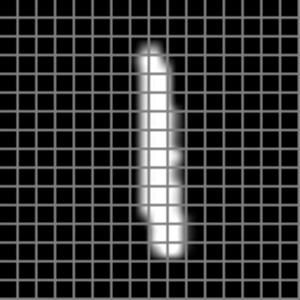
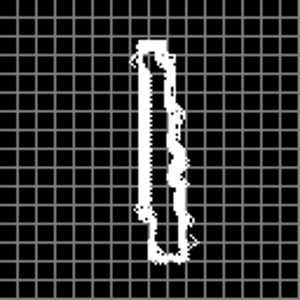
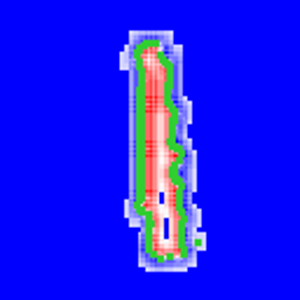
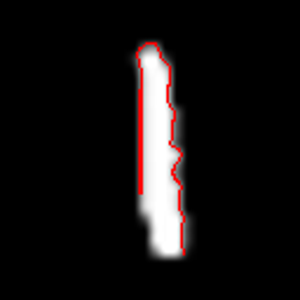

In [624]:
sensor_state_images = []

for sense_vector in sense_vectors:
    sensor_state_image = Image.new('L', (config.sample_size, config.sample_size), color='black')
    sensor_state_image = lay_grid(sensor_state_image, 8)
    sensor_state_image_draw = ImageDraw.Draw(sensor_state_image)

    for sensor_index, state_index in enumerate(sense_vector):
        if state_index == -1:
            continue
        
        sensor_instance = SENSOR_INSTANCES_INFO.loc[sensor_index]
        sensor_state = SENSOR_STATES_INFO.loc[[state_index]] # avoid type coercion with returning subdf [[state_index]] instead of returning Series [state_index]

        x_center = sensor_instance.x_center
        y_center = sensor_instance.y_center
        k = sensor_instance['size'] / 2
        sweep1_vec = sensor_state.sweep1_vec.iloc[0]
        sweep2_vec = sensor_state.sweep2_vec.iloc[0]
        
        line_start = x_center, y_center
        line_end = x_center + sweep1_vec.real * k, y_center + sweep1_vec.imag * k
        sensor_state_image_draw.line([line_start, line_end], fill='white')
        
        line_start = x_center, y_center
        line_end = x_center + sweep2_vec.real * k, y_center + sweep2_vec.imag * k
        sensor_state_image_draw.line([line_start, line_end], fill='white')
    
    sensor_state_images.append(sensor_state_image)

altitude_color_map = mpl.colormaps['bwr']
altitude_images = []

for image in images:
    image_pil = Image.frombytes('L', size=(config.sample_size, config.sample_size), data=image.ravel())
    image_pil = image_pil.convert('RGB')
    image_pil = lay_grid(image_pil, 8)
    draw = ImageDraw.Draw(image_pil)
    min_max_scaler = preprocessing.MinMaxScaler()
    altitude_map_scaled = min_max_scaler.fit_transform(altitude_map_lores.reshape(-1, 1)).reshape(altitude_map_lores.shape)

    for y in range(altitude_map_lores.shape[0]):
        for x in range(altitude_map_lores.shape[1]):
            color = altitude_color_map(altitude_map_scaled[y, x], bytes=True)
            draw.point((x, y), fill=color)

    for _, si in df_sensor_instances.iterrows():
        draw.rectangle([si.x_center_orig - 1, si.y_center_orig - 1, si.x_center_orig + 1, si.y_center_orig + 1], outline='limegreen', fill='limegreen')
    
    altitude_images.append(image_pil)
    
seq_images = []

for image in images:
    image_pil = Image.frombytes('L', size=(config.sample_size, config.sample_size), data=image.ravel())
    image_pil = image_pil.convert('RGB')
    draw = ImageDraw.Draw(image_pil)

    for seq in sequences:
        for pt_from, pt_to in zip(seq, seq[1:]):
            draw.line([pt_from[0], pt_from[1], pt_to[0], pt_to[1]], width=1, fill='red')

    seq_images.append(image_pil)

all_images = list(map(lambda i: lay_grid(matrix_to_image(i), 8), images)) + sensor_state_images + altitude_images +  seq_images
display_images(list(map(lambda i: i.resize((300, 300)), all_images)))